In [1]:
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch._dynamo
from torch._dynamo import debug_utils 

import math
import time
import inspect
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

try:
  import tiktoken
except:
  !pip install tiktoken
  import tiktoken

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

Define device

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
  device = torch.device("mps")
else:
  device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


Define config and values

In [4]:
#---------------------------------------------------------------------------

@dataclass(frozen=True)
class GPTConfig:
  block_size: int = 64 # max sequence length
  vocab_size: int = 50304 # num of tokens
  n_embd: int = 128 # embedding dimension
  n_head: int = 4 # num of heads
  n_layer: int = 4 # num of layers

Creating main blocks of GPT architecture

In [5]:
# Self-Attention block
class CausalSelfAttention(nn.ModuleDict):
  def __init__(self, config):
    super().__init__()
    assert config.n_embd & config.n_head == 0

    # key, query, value projections for all heads, but in a batch
    self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
    # output projection
    self.c_proj = nn.Linear(config.n_embd, config.n_embd)
    self.c_proj.NANOGPT_SCALE_INIT = 1
    # regularization
    self.n_head = config.n_head
    self.n_embd = config.n_embd

    # creating a mask for setting attention of future tokens to 0
    self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
    .view(1, 1, config.block_size, config.block_size))

  def forward(self, x):
    B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

    # calculate query, key, values for all heads in batch and mode head forward
    qkv = self.c_attn(x)
    q, k, v = qkv.split(self.n_embd, dim=2)
    q = q.view(B, T, self.n_head, C // self.n_head).transpose(1,2) # (B, nh, T, hs)
    k = k.view(B, T, self.n_head, C // self.n_head).transpose(1,2) # (B, nh, T, hs)
    v = v.view(B, T, self.n_head, C // self.n_head).transpose(1,2) # (B, nh, T, hs)

    # attention (materializes the large (T, T) matrix for all queries and keys)
    att = (q @ k.transpose(-2,-1))*(1.0 / math.sqrt(k.size(-1)))
    att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
    att = F.softmax(att, dim=-1)
    y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
    #y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
    
    y = y.transpose(1,2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
    y = self.c_proj(y)
    return y

# Multi-layer Perceptron
class MLP(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd) # expansion layer
    self.gelu = nn.GELU(approximate='tanh')
    self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd) # projection layer
    self.c_proj.NANOGPT_SCALE_INIT = 1

  def forward(self, x):
    x = self.c_fc(x)
    x = self.gelu(x)
    x = self.c_proj(x)
    return x

class Block(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.ln_1 = nn.LayerNorm(config.n_embd)
    self.attn = CausalSelfAttention(config)
    self.ln_2 = nn.LayerNorm(config.n_embd)
    self.mlp = MLP(config)

  def forward(self, x):
    x = x + self.attn(self.ln_1(x))
    x = x + self.mlp(self.ln_2(x))
    return x

Create GPT class that unites everything

In [6]:
class GPT(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.config = config

    self.transformer = nn.ModuleDict(dict(
        wte = nn.Embedding(config.vocab_size, config.n_embd), # word token embedding
        wpe = nn.Embedding(config.block_size, config.n_embd), # word position embedding
        h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # hidden layers
        ln_f = nn.LayerNorm(config.n_embd)
    ))
    self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    # weight sharing scheme
    self.transformer.wte.weight = self.lm_head.weight

    # init params
    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      std = 0.02
      # scale down the weights on 1/sqrt(N) where N is number of residual layers
      if hasattr(module, 'NANOGPT_SCALE_INIT'):
        std *= (2 * self.config.n_layer) ** -0.5
      torch.nn.init.normal_(module.weight, mean=0.0, std=std)
      if module.bias is not None:
        torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, idx, targets=None):
    B, T = idx.size()

    assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is"

    # forward the token and position embeddings
    pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
    pos_emb = self.transformer.wpe(pos)
    tok_emb = self.transformer.wte(idx)
    x = tok_emb + pos_emb

    # forward the blocks of the transformer
    for block in self.transformer.h:
      x = block(x)

    # forward the final layernorm and classifier
    x = self.transformer.ln_f(x)
    logits = self.lm_head(x) # (B, T, vocab_size)

    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
    return logits, loss


In [7]:
from torchinfo import summary
model = GPT(GPTConfig()).to(device)
#print(model)
summary(model, input_size=(4, 64), dtypes=[torch.long])

Layer (type:depth-idx)                             Output Shape              Param #
GPT                                                [4, 64, 50304]            --
├─ModuleDict: 1-1                                  --                        --
│    └─Embedding: 2-1                              [64, 128]                 8,192
│    └─Embedding: 2-2                              [4, 64, 128]              6,438,912
│    └─ModuleList: 2-3                             --                        --
│    │    └─Block: 3-1                             [4, 64, 128]              198,272
│    │    └─Block: 3-2                             [4, 64, 128]              198,272
│    │    └─Block: 3-3                             [4, 64, 128]              198,272
│    │    └─Block: 3-4                             [4, 64, 128]              198,272
│    └─LayerNorm: 2-4                              [4, 64, 128]              256
├─Linear: 1-2                                      [4, 64, 50304]            6,438,9

Create DataLoader to load the dataset in batches

In [8]:
class DataLoaderLite:
  def __init__(self, B, T):
    self.B = B
    self.T = T

    # load tokens form disk and store them in memory
    with open('input.txt', 'r') as f:
      text = f.read()
    enc = tiktoken.get_encoding('gpt2')
    self.tokens = torch.tensor(enc.encode(text))
    print(f"Loaded {len(self.tokens)} tokens")
    print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

    # state
    self.current_position = 0

  def next_batch(self):
    B, T = self.B, self.T
    buf = self.tokens[self.current_position:self.current_position + B * T + 1]
    x = buf[:-1].view(B,T) # inputs
    y = buf[1:].view(B,T) # targets
    # advance the position of the tensor
    self.current_position += B * T
    # if loading the next batch would be out of bounss, then reset
    if self.current_position + self.B * self.T >= len(self.tokens):
      print(self.current_position)
      self.current_position = 0
    return x, y

Get dataset and try to train the model


In [9]:
#----------------------------------------------------------
# Set batch sizes and calculate gradient accumulation steps
#total_batch_size = 524288 # 2**19, around 0.5M in number of tokens
B = 32 # micro-batch size, best used is 64
T = 64 # sequence length
total_batch_size = B*T
assert total_batch_size % (B * T) == 0, "Total batch size should be divisible by B * T"
grad_accum_steps = total_batch_size // (B * T)
print(f"Total desired batch size: {total_batch_size}")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")
# Get DataLoader
train_loader = DataLoaderLite(B=B, T=T)
#----------------------------------------------------------
# Set precision for float and compile the model
torch.set_float32_matmul_precision('high')
model.train()
model = torch.compile(model, backend="aot_eager")
model.to(device)
print("Model compiled!")
torch.manual_seed(42)
torch.mps.manual_seed(42)
#----------------------------------------------------------
# warmup + decay implementation
max_lr = 3e-3 # best used 3e-3
min_lr = 3e-4 # best used 3e-5
warmup_steps = 500 # best used 10
max_steps = 8000 # best used 2000
def get_lr(it):
  # linear warmup
  if it < warmup_steps:
    return max_lr * (it+1) / warmup_steps
  if it > max_steps:
    return min_lr
  # cosine decay
  decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
  assert 0 <= decay_ratio <= 1
  coeff = 0.5 * (1 + math.cos(math.pi * decay_ratio))
  return min_lr + coeff * (max_lr - min_lr)
#----------------------------------------------------------
print("Start training:")
loss_history = []
num_steps = 8000
# Do the optimization
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.1)
for step in range(num_steps):
  t0 = time.time()
  optimizer.zero_grad()
  loss_accum = 0
  for micro_step in range(grad_accum_steps):
      # get the next batch of data
      x, y = train_loader.next_batch()
      x, y = x.to(device), y.to(device)
      with torch.autocast(device_type='mps', dtype=torch.float16):
        logits, loss = model(x,y)
      loss = loss / grad_accum_steps
      loss_accum += loss.detach()
      loss.backward()

  norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping

  # perform learning rate warmup and decay
  lr = get_lr(step)
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

  optimizer.step()

  torch.mps.synchronize()
  t1 = time.time()
  dt = t1 - t0 # time diff in seconds

  tokens_processed = train_loader.B * train_loader.T * grad_accum_steps
  tokens_per_sec = tokens_processed / dt

  loss_history.append(loss_accum)
  print(f"step {step} | loss: {loss_accum.item()} | lr: {lr} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/s: {tokens_per_sec:.2f}")

Total desired batch size: 2048
=> calculated gradient accumulation steps: 1
Loaded 338025 tokens
1 epoch = 165 batches
Model compiled!
Start training:
step 0 | loss: 10.808528900146484 | lr: 6e-06 | norm: 3.7514 | dt: 2045.66ms | tok/s: 1001.15
step 1 | loss: 10.81307601928711 | lr: 1.2e-05 | norm: 3.8562 | dt: 274.60ms | tok/s: 7458.22
step 2 | loss: 10.779071807861328 | lr: 1.8e-05 | norm: 4.2753 | dt: 276.04ms | tok/s: 7419.30
step 3 | loss: 10.775985717773438 | lr: 2.4e-05 | norm: 3.8899 | dt: 278.09ms | tok/s: 7364.58
step 4 | loss: 10.766464233398438 | lr: 2.9999999999999997e-05 | norm: 3.6879 | dt: 293.39ms | tok/s: 6980.42
step 5 | loss: 10.741413116455078 | lr: 3.6e-05 | norm: 3.6125 | dt: 278.46ms | tok/s: 7354.69
step 6 | loss: 10.68502426147461 | lr: 4.2000000000000004e-05 | norm: 3.6729 | dt: 286.53ms | tok/s: 7147.52
step 7 | loss: 10.6612548828125 | lr: 4.8e-05 | norm: 3.1109 | dt: 275.21ms | tok/s: 7441.52
step 8 | loss: 10.607925415039062 | lr: 5.4e-05 | norm: 2.9573 |

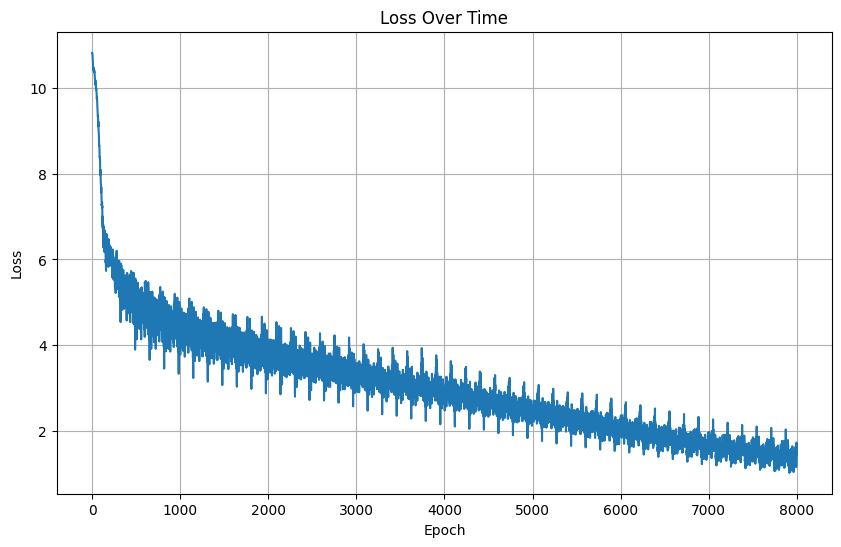

In [10]:
#----------------------------------------------------------

# Convert loss_history tensors to CPU and then to float
loss_history_cpu = [item.cpu().item() for item in loss_history]
# Plot loss curve
data = {
  'Epoch': list(range(0,len(loss_history_cpu))),
  'Loss': loss_history_cpu
}
df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Epoch', y='Loss')

# Customize the plot
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

In [11]:
num_return_sequences = 5
max_length = 64

model.eval()
model.to(device)

enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("\n")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
x = tokens.to(device)

#torch.manual_seed(42)
#torch.mps.manual_seed(42)
while x.size(1) < max_length:
  with torch.no_grad():
    logits, loss = model(x)
    logits = logits[:, -1, :] # last position
    probs = F.softmax(logits, dim=-1) # get probabilities
    topk_probs, topk_indices = torch.topk(probs, 50, dim=-1) # do top-k sampling of 50
    ix = torch.multinomial(topk_probs, 1) # select a token from top-k probabilities
    xcol = torch.gather(topk_indices, -1, ix) # gather the corresponding indices
    x = torch.cat((x, xcol), dim=1) # append to the sequence

for i in range(num_return_sequences):
  tokens = x[i, :max_length].tolist()
  decoded = enc.decode(tokens)
  print(">", decoded)

> 
Which they keep in silent hours stain with blood,
With liege honour ofal; we have no than those,
But, what, in the Capulets me!

JULIET:
'Ties-by are well met; and what noise is they now
Nurse:
> 
That it is but this is it, I stand but my husband.
LADY CAPULET:
Al'! God, God, speak.
Who is the want of nine by's bosom there:
Be sworn for lesser purpose I will follow me.

JULIET:
> 
And that dead time of York is join'd death:
Examine other rose thread,
And wantons, great perforce.
Fair cousin: then, sirrah,--

NORFRIAR LAURENCE:
Hush, gentle-hearted mother.

PETRUCHIO
> 
DUKE OF SURREY:
His light and virtue is well proclaim'd mild;
It is well consul, are we? say on this way?

DUKE OF YORK:

Messenger:
It is the enterprise onards: threatening made wholesome thoughts
Were for
> 
such a case as loathsome of a grief;
And I have a feeling in mine way, did usurp,
With Rosaline's valour in point:
I'll like unaunt with his friends,
To keep tears' poison with thy fair safety.

JULIET:


In [12]:
print(torch.backends.mps.is_built())
print(torch.backends.mps.is_available())

True
True


In [13]:
torch.save(model.state_dict(), "gpt2_model_weights.pth")

: 